# Load libaray

In [104]:
# Standard library imports
import warnings

# Third-party imports for data manipulation and numerical operations
import numpy as np
import pandas as pd
import joblib

# Imports for visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Machine learning and statistical analysis imports
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from scipy.stats import uniform, linregress

# Imports for mapping
from mpl_toolkits.basemap import Basemap

# Configuration to suppress specific warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


# Train the GMM_brLCP model

In [106]:
# Load the surface sediments data from Tibetan Plateau
data = pd.read_excel('Liang et al., 2024 Lacutrine brGDGT and BGC brGDGTs202407.xlsx', sheet_name='Table S1. ss_brGDGTs')
new_df = data[["MBT'5me", 'IR']]

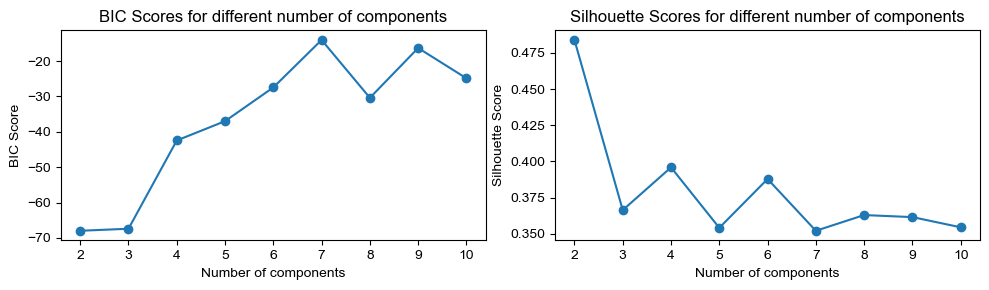

In [108]:
# Initialize variables
bic_scores = []
sil_scores = []

# Evaluate GMM models with different number of components
n_components_range = range(2, 11)

for n_components in n_components_range:
    param_dist = {
        'n_components': [n_components],
        'covariance_type': ['full']
    }

    # Initialize the GaussianMixture model
    gmm = GaussianMixture(random_state=42)

    # Initialize the RandomizedSearchCV object
    random_search = RandomizedSearchCV(gmm, param_distributions=param_dist, n_iter=1, cv=5, random_state=42)

    # Fit the model to the data
    random_search.fit(new_df)

    # Get the best model
    best_gmm = random_search.best_estimator_

    # Fit the best model to the data
    best_gmm.fit(new_df)

    # Compute BIC
    bic_scores.append(best_gmm.bic(new_df))

    # Compute Silhouette Score
    labels = best_gmm.predict(new_df)
    sil_scores.append(silhouette_score(new_df, labels))

# Plot BIC scores
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores for different number of components')
plt.xlabel('Number of components')
plt.ylabel('BIC Score')

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(n_components_range, sil_scores, marker='o')
plt.title('Silhouette Scores for different number of components')
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



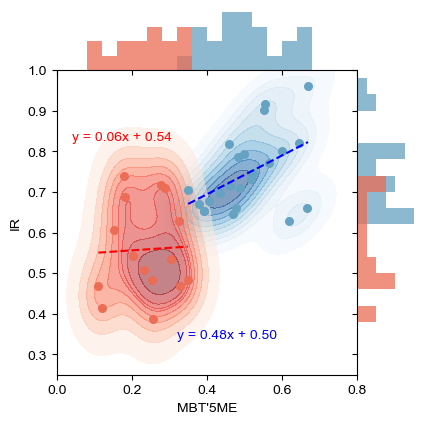

In [112]:
# Import the Gaussian Mixture Model from the mixture module
loaded_gmm = mixture.GaussianMixture(n_components=2, covariance_type="full", random_state=42)

# Fit the model on the new data and predict the labels, incrementing labels by 1 for better readability
labels = loaded_gmm.fit_predict(new_df) + 1

# Copy the original dataframe and add the predicted labels as a new column
data_with_labels = new_df.copy()
data_with_labels['Label'] = labels
data_with_labels['Bias_MAFrf']=data['Bias_MAFrf']
# Display the dataframe with labels
data_with_labels

# Extract the 'MBT'5me' and 'IR' values for both labels for plotting
x1 = data_with_labels[data_with_labels['Label'] == 1]["MBT'5me"]
y1 = data_with_labels[data_with_labels['Label'] == 1]['IR']
x2 = data_with_labels[data_with_labels['Label'] == 2]["MBT'5me"]
y2 = data_with_labels[data_with_labels['Label'] == 2]['IR']

# Initialize a joint grid for the plot with specific dimensions and limits
g = sns.JointGrid(space=0)
g.fig.set_size_inches(4, 4)
g.ax_joint.set_ylim(0.25, 1)
g.ax_joint.set_xlim(0, 0.8)

# Set bin width for histograms
binwidth = 0.04

# Define custom hex colors for the two different groups
hex_color1 = "#EC6C55"
hex_color2 = "#66A2C1"

# Plot data and kernel density plots for each group
sns.kdeplot(x=x1, y=y1, ax=g.ax_joint, cmap="Blues", alpha=0.5, fill=True)
sns.kdeplot(x=x2, y=y2, ax=g.ax_joint, cmap="Reds", alpha=0.5, fill=True)
sns.histplot(x=x1, ax=g.ax_marg_x, color=hex_color2, bins=np.arange(0, 0.8 + binwidth, binwidth), edgecolor='none')
sns.histplot(y=y1, ax=g.ax_marg_y, color=hex_color2, bins=np.arange(0.1, 1 + binwidth, binwidth), edgecolor='none')
sns.histplot(x=x2, ax=g.ax_marg_x, color=hex_color1, bins=np.arange(0, 0.8 + binwidth, binwidth), edgecolor='none')
sns.histplot(y=y2, ax=g.ax_marg_y, color=hex_color1, bins=np.arange(0.1, 1 + binwidth, binwidth), edgecolor='none')

# Scatter plots for visual differentiation
g.ax_joint.scatter(x1, y1, color=hex_color2, s=30)
g.ax_joint.scatter(x2, y2, color=hex_color1, s=30)

# Function to add linear regression lines and equations to the plots
def add_regression_line(x, y, color, ax, pos):
    slope, intercept, _, _, _ = linregress(x, y)
    x_vals = np.linspace(min(x), max(x), 100)  # Limit X values between the minimum and maximum data points
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color=color, linestyle='--')
    equation = f"y = {slope:.2f}x + {intercept:.2f}"
    ax.text(pos[0], pos[1], equation, transform=ax.transAxes, color=color, verticalalignment='top')

add_regression_line(x1, y1, "b", g.ax_joint, pos=(0.4, 0.15))
add_regression_line(x2, y2, "r", g.ax_joint, pos=(0.05, 0.80))

# Disable grid lines for a cleaner look
g.ax_joint.grid(False)
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)

# Set titles and labels for the axes
g.set_axis_labels("MBT'5ME", "IR")

# Optionally, save the figure to a file
#plt.savefig("D:\D-Holocene T2024\Figure\GMM_figure202400717.pdf", format='pdf')

# Display the plot
plt.show()


# Validate global surface sediment samples by GMM_brLCP model

In [76]:
# Load the model from the file
loaded_gmm = joblib.load('brLCP_lake.pkl')

# Lading the global dataset
Global_data = pd.read_excel('Liang et al., 2024_global and holocene dataset.xlsx', sheet_name='Global lacustrine SS')

# # Checking if the column "MBT'5Me" exists in the DataFrame, and if so, renaming it
if "MBT'5Me" in Global_data.columns:
    Global_data = Global_data.rename(columns={"MBT'5Me": "MBT'5me"})
# Drop rows with NA values in specific columns
columns_to_check = ["MBT'5me", 'IR', 'Salinity (g/L)', 'PH']
Global_data = Global_data.dropna(subset=columns_to_check)
Global_X = Global_data[["MBT'5me", 'IR']]
predicted_labels = loaded_gmm.predict(Global_X)
Global_data['Predicted_Labels'] = predicted_labels + 1
Global_data['Bacterial Cluster'] = ''
Global_data.loc[Global_data['Predicted_Labels'] == 2, 'Bacterial Cluster'] = 'fres'
Global_data.loc[Global_data['Predicted_Labels'] == 1, 'Bacterial Cluster'] = 'salt'

Global_data['PH predict'] = ''
Global_data.loc[Global_data['Predicted_Labels'] == 2, 'PH predict'] = 'acid'
Global_data.loc[Global_data['Predicted_Labels'] == 1, 'PH predict'] = 'alke'

Global_data['Bacterial Cluster'].unique()
Global_data['Salinity'] = np.where(Global_data['Salinity (g/L)'] > 0.2, 'salt', 'fres')
Global_data['PH-value'] = np.where(Global_data['PH'] >8, 'alke', 'acid')
print(len(Global_data))

415


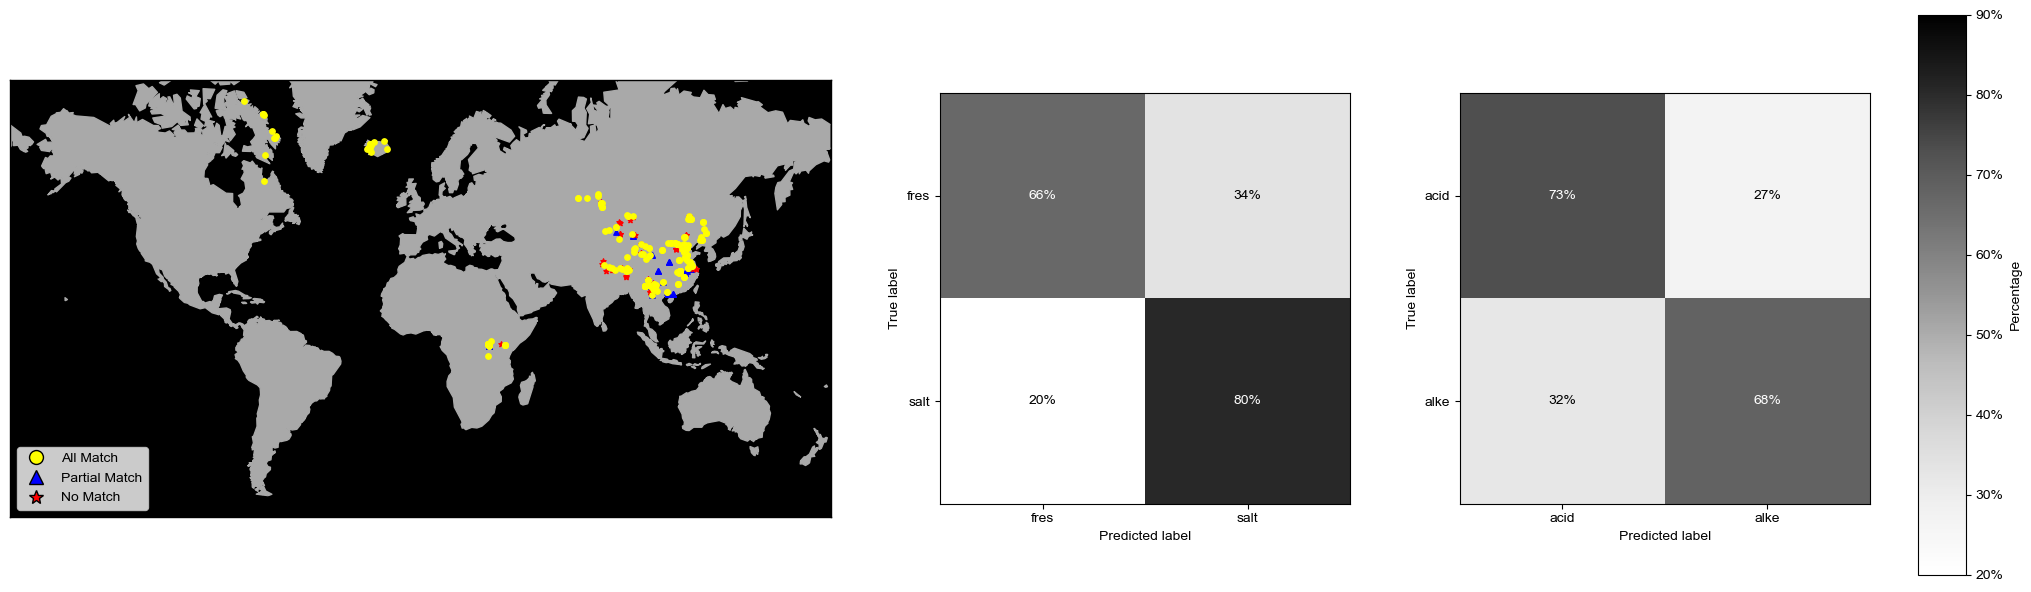

In [98]:
# Create figure and grid layout
fig = plt.figure(figsize=(24, 8))
gs = GridSpec(1, 3, width_ratios=[2, 1, 1])

# Map plotting
ax0 = fig.add_subplot(gs[0, 0])
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=75, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c', ax=ax0)
m.drawcoastlines(color='darkgray')
m.fillcontinents(color='darkgray', lake_color='darkgray')
m.drawmapboundary(fill_color='black')

# Calculate projected coordinates for longitude and latitude
Global_data['x'], Global_data['y'] = m(Global_data['longitude'].values, Global_data['latitude'].values)

# Define markers and colors
marker_colors = {
    'all_match': ('o', 'yellow'),
    'partial_match': ('^', 'blue'),
    'no_match': ('*', 'red')
}

# Plot points and set legend
# First plot blue triangles and red stars
for idx, row in Global_data.iterrows():
    # Determine marker shape and color
    if (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'acid' and row['Salinity'] == 'salt') or \
       (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'alke' and row['Salinity'] == 'fres'):
        marker, color = marker_colors['partial_match']
    elif (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'alke' and row['Salinity'] == 'salt') or \
         (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'acid' and row['Salinity'] == 'fres'):
        marker, color = marker_colors['no_match']
    else:
        continue
    
    # Plot points
    m.scatter(row['x'], row['y'], marker=marker, color=color, s=15, zorder=5)

# Finally, plot yellow circles
for idx, row in Global_data.iterrows():
    if (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'acid' and row['Salinity'] == 'fres') or \
       (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'alke' and row['Salinity'] == 'salt'):
        marker, color = marker_colors['all_match']
        
        # Plot points
        m.scatter(row['x'], row['y'], marker=marker, color=color, s=15, zorder=5)

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], marker='o',  color='none',  markerfacecolor='yellow', markersize=10, label='All Match'),
    plt.Line2D([0], [0], marker='^', color='none', markerfacecolor='blue', markersize=10, label='Partial Match'),
    plt.Line2D([0], [0], marker='*', color='none',  markerfacecolor='red', markersize=10, label='No Match')
]

# Add legend to the map
ax0.legend(handles=legend_elements, loc='lower left')

# Part 1: Bacterial Cluster vs Salinity
y_true1 = Global_data['Salinity']
y_pred1 = Global_data['Bacterial Cluster']
conf_matrix1 = confusion_matrix(y_true1, y_pred1, labels=['fres', 'salt'])
conf_matrix_percentage1 = conf_matrix1.astype('float') / conf_matrix1.sum(axis=1)[:, np.newaxis] * 100

# Confusion matrix 1
ax1 = fig.add_subplot(gs[0, 1])
cmap = plt.get_cmap('Greys')
norm = plt.Normalize(vmin=20, vmax=90)
im1 = ax1.imshow(conf_matrix_percentage1, interpolation='nearest', cmap=cmap, norm=norm)

# Set axis labels
ax1.set(xticks=np.arange(conf_matrix1.shape[1]),
        yticks=np.arange(conf_matrix1.shape[0]),
        xticklabels=['fres', 'salt'], yticklabels=['fres', 'salt'],
        ylabel='True label',
        xlabel='Predicted label')

# Display percentage in each cell
thresh1 = conf_matrix_percentage1.max() / 2.
for i in range(conf_matrix1.shape[0]):
    for j in range(conf_matrix1.shape[1]):
        if conf_matrix1[i, j] != 0:  # Only display non-zero values
            ax1.text(j, i, f'{conf_matrix_percentage1[i, j]:.0f}%',
                     ha='center', va='center',
                     color='white' if conf_matrix_percentage1[i, j] > thresh1 else 'black')

# Part 2: Bacterial Cluster vs pH
Global_data = Global_data.dropna(subset=['PH'])
Global_data['PH-value'] = np.where(Global_data['PH'] >= 7, 'alke', 'acid')
y_true2 = Global_data['PH-value']
y_pred2 = Global_data['PH predict']
conf_matrix2 = confusion_matrix(y_true2, y_pred2, labels=['acid', 'alke'])
conf_matrix_percentage2 = conf_matrix2.astype('float') / conf_matrix2.sum(axis=1)[:, np.newaxis] * 100

# Confusion matrix 2
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(conf_matrix_percentage2, interpolation='nearest', cmap=cmap, norm=norm)

# Set axis labels
ax2.set(xticks=np.arange(conf_matrix2.shape[1]),
        yticks=np.arange(conf_matrix2.shape[0]),
        xticklabels=['acid', 'alke'], yticklabels=['acid', 'alke'],
        ylabel='True label',
        xlabel='Predicted label')

# Display percentage in each cell
thresh2 = conf_matrix_percentage2.max() / 2.
for i in range(conf_matrix2.shape[0]):
    for j in range(conf_matrix2.shape[1]):
        if conf_matrix2[i, j] != 0:  # Only display non-zero values
            ax2.text(j, i, f'{conf_matrix_percentage2[i, j]:.0f}%',
                     ha='center', va='center',
                     color='white' if conf_matrix_percentage2[i, j] > thresh2 else 'black')

# Add shared color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Modify the position and size of the color bar
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Percentage')
cbar.set_ticks(np.arange(20, 91, 10))
cbar.set_ticklabels([f'{int(tick)}%' for tick in np.arange(20, 91, 10)])

# Adjust layout
#plt.tight_layout(rect=[0, 0, 0.9, 1])
#plt.savefig('Global Data Points Map.pdf', format='pdf')
plt.show()


# Predict Holocene records using GMM_brLCP model

In [114]:
# Load the model from the file
loaded_gmm = joblib.load('brLCP_lake.pkl')

In [116]:
def plot_scatter(data, age_col, label_col, predicted_labels_col, title=None):
    rcParams['font.family'] = 'Arial'
    rcParams['font.size'] = 10 

    data.loc[data[predicted_labels_col] == 2, label_col] = 'Freshwater Species'
    data.loc[data[predicted_labels_col] == 1, label_col] = 'Halo-alkalophylic Species'

    plt.figure(figsize=(5, 3))
 
    colors = {'Freshwater Species': 'red', 'Halo-alkalophylic Species': 'blue'}

    for label, color in colors.items():
        subset = data[data[label_col] == label]
        plt.scatter(subset[age_col], [1] * len(subset), c=color, label=label, alpha=0.5, edgecolor='k')

    plt.legend()
    plt.title(title if title else "")
    plt.xlabel('Age (BP)')
    plt.yticks([1], ['Bacterial Cluster'])  
    plt.ylabel('')
    plt.grid(False)
    plt.show()


QH: ['Halo-alkalophylic Species']


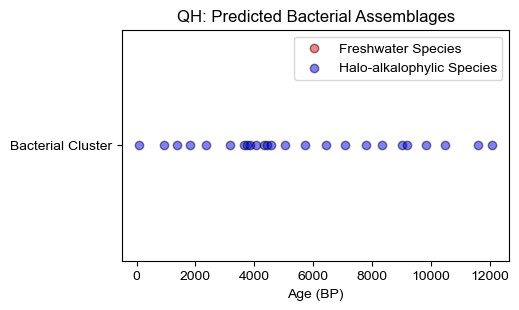

BGC: ['Freshwater Species' 'Halo-alkalophylic Species']


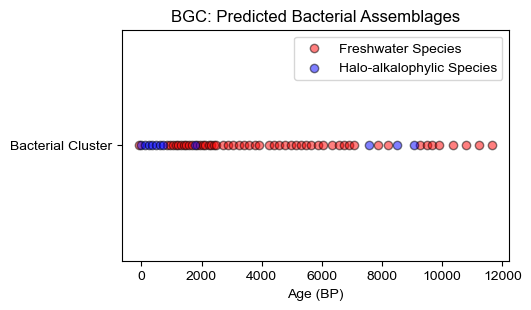

NG: ['Halo-alkalophylic Species' 'Freshwater Species']


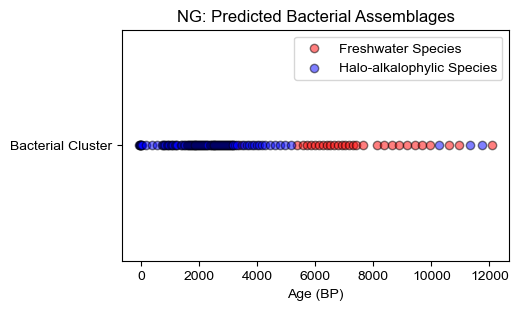

GH: ['Freshwater Species']


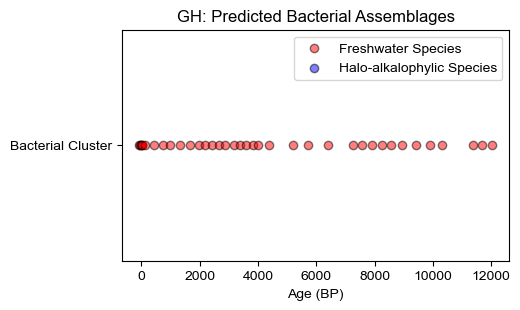

CQ: ['Freshwater Species']


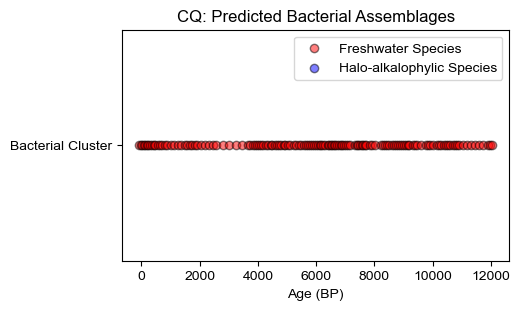

TCQH: ['Freshwater Species']


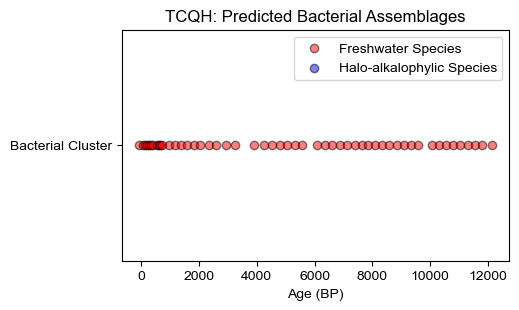

LG: ['Freshwater Species']


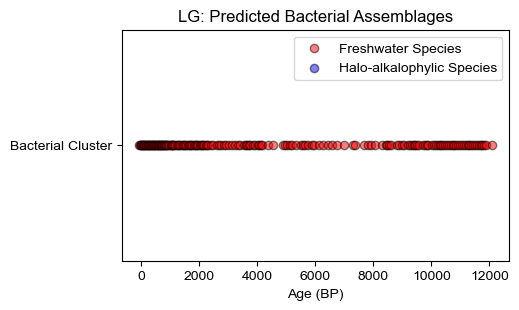

TC: ['Freshwater Species']


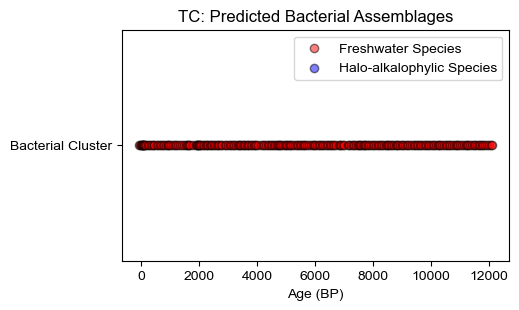

In [120]:
# List of Lake name
sheet_names = ["QH","BGC","NG","GH", "CQ", "TCQH","LG", "TC"]# 

# Loop through each sheet name
for sheet_name in sheet_names:
    # Read the data
   #data = pd.read_excel('Holocne-records brGDTS.xlsx', sheet_name=sheet_name)
    
    data = pd.read_excel('Liang et al., 2024_global and holocene dataset.xlsx', sheet_name=sheet_name)
    data.columns = data.iloc[0]
    data = data[1:].reset_index(drop=True)
  
    # Clean and preprocess the data
    if "MBT'5Me" in data.columns:
        data = data.rename(columns={"MBT'5Me": "MBT'5me"})
    data = data.dropna(subset=["MBT'5me", 'IR'])

    # Prepare the features for prediction
    X = data[["MBT'5me", 'IR']]

    # Predict the labels using the GMM model
    predicted_labels = loaded_gmm.predict(X)
    data['Predicted_Labels'] = predicted_labels + 1

    # Map the predicted labels to bacterial clusters
    data['Bacterial Cluster'] = ''
    data.loc[data['Predicted_Labels'] == 2, 'Bacterial Cluster'] = 'Freshwater Species'
    data.loc[data['Predicted_Labels'] == 1, 'Bacterial Cluster'] = 'Halo-alkalophylic Species'

    # Print unique bacterial clusters for verification
    print(f"{sheet_name}: {data['Bacterial Cluster'].unique()}")

    # Plot the scatter plot with the site name as the title
    plot_scatter(data, 'Age (BP)', 'Bacterial Cluster', 'Predicted_Labels', title=f"{sheet_name}: Predicted Bacterial Assemblages")
